## House Price Prediction Assignment

### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. 

We are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


### Business Goals:

The company wants to know:
1. Which variables are significant in predicting the price of a house, and
2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.


### Steps:

#### 1. Data Sourcing

    1. Checking the encoding of the file
    2. Loading the data		

#### 2. Data Exploring & Cleaning

    A. Null Values Analysis
        1. Identify and drop columns with 100% missing data
        2. Identify and drop columns with more than 80% missing data
        3. Identify and drop columns having single unique values as they will not any value to the analysis
        4. Identify and drop unnecessary columns (like text based, Applicant Loan Behaviour)

    B. Datatype Check 

    C. Datatype Conversion
        1. Converting int to object
    
    D. Drop Records
        1. Drop Duplicates
    
    E. Impute Null Values
    
    F. Populating the categorical columns with correct mapping
    
    G. Outliers handling
    
    G. Derived Metrics
    
#### 3. Data Visualisation
#### 4. Data Preparation
#### 5. Splitting and Scaling the data
#### 6. Model Building & Evaluation
#### 7. Regualisation using Ridge and Lasso
######################################################################

## Step 1: Data Sourcing

In [1]:
# Importing all required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from pandas.api.types import is_object_dtype,is_string_dtype, is_numeric_dtype

%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
py.offline.init_notebook_mode(connected=True) # plotting in offilne mode 
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
pd.set_option('display.max_colwidth', 1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 

In [2]:
# Generic Functions

# Method to get Meta-Data about any dataframe passed 
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': round(dataframe.isnull().sum()/len(dataframe) * 100,2) ,# percentage of null values
                    'Unique_Value': dataframe.nunique()
                       })
    return metadata_matrix

def getVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def binary_map(x):
    return x.map({'yes': 1, "no": 0})

def cross_validation(X_train,y_train,lm):
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    hyper_params = [{'n_features_to_select': list(range(len(X_train.columns)))}]
    lm.fit(X_train, y_train)
    rfe = RFE(lm)             
    model_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    model_cv.fit(X_train, y_train)                  
    cv_results = pd.DataFrame(model_cv.cv_results_)
    plt.figure(figsize=(16,6))
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r2')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')
    
def plot_bar_chart(plotting_frame,x_column,y_column) :
            
        x_axis_title = x_column.title()
        y_axis_title = y_column.title()
        
        graph_title = "Bar Chart [" + x_axis_title.title() + " Vs " + y_axis_title.title() + "]"
        
        layout = go.Layout(
             title = graph_title,
             yaxis=dict(
                title=y_axis_title
             ),
             xaxis=dict(
                 title=x_axis_title
             )
        )

        data_to_be_plotted = [
            go.Bar(
                x=plotting_frame[x_column], 
                y=plotting_frame[y_column]
            )
        ]


        figure = go.Figure(data=data_to_be_plotted,layout=layout)
        py.offline.iplot(figure)
        
        
def plot_pie_chart(plotting_frame,x_column,y_column) : 
        
        labels = plotting_frame[x_column].tolist()
        values = plotting_frame[y_column].tolist()

        trace = go.Pie(labels=labels, values=values)

        py.offline.iplot([trace])

        
def plot_box_chart(dataframe) :
    data = []
    for index, column_name in enumerate(dataframe) :
        data.append(
        go.Box(
            y=dataframe.iloc[:, index],
            name=column_name
         ))   
        
    layout = go.Layout(
    yaxis=dict(
        title="Frequency",
        zeroline=False
    ),
       boxmode='group'
    )
    
    fig = go.Figure(data=data, layout=layout)    
    py.offline.iplot(fig) 
    
def plot_group_bar_chart(plot,col,hue) : 
    hue_col = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(plot[col].unique()) + 6 + 5*len(hue_col.unique())
    fig.set_size_inches(width , 10)
    ax = sns.countplot(data = loan_plot, x= col, order=plot[col].value_counts().index,hue = hue,palette="Set2") 
    
    for p in ax.patches:
                # Some segment wise value we are getting as Nan as respective value not present to tackle the Nan using temp_height
                temp_height = p.get_height()
                
                if math.isnan(temp_height):
                    temp_height = 0.01
                    
                
                ax.annotate('{:1.1f}%'.format((temp_height*100)/float(len(loan_plot))), (p.get_x()+0.05, temp_height+20)) 
    
    plt.show()

def col_list(df):
    num_list = []
    cat_list = []
    for column in df:
        if is_numeric_dtype(df[column]):
            num_list.append(column)
        elif is_object_dtype(df[column]):
            cat_list.append(column)    
    return cat_list,num_list

def outliers(df,num_list):
    oc = []
    noc=[]
    l=[]
    u=[]
    for c in num_list:
        data=df[c].values
        lower, upper = np.mean(data) - (np.std(data) * 3), np.mean(data) + (np.std(data) * 3)
        outliers=len([x for x in data if x < lower or x > upper])
        non_outliers=len([x for x in data if x >= lower and x <= upper])
        l.append(lower)
        u.append(upper)
        oc.append(outliers)
        noc.append(non_outliers)
    oc_metric = pd.Series(oc, name = 'Outliers')
    noc_metric = pd.Series(noc, name = 'Non-Outliers')
    lower_limit = pd.Series(l, name = 'Lower Limit')
    uper_limit = pd.Series(u, name = 'Upper Limit')    
    outl = pd.DataFrame(num_list,columns = ['Columns'])
    final_metric = pd.concat([outl, oc_metric, noc_metric,lower_limit,uper_limit], axis = 1)
 #   final_metric.set_index("Columns", inplace = True)
    return final_metric    

def assumption_graph(y_train,y_pred_train):
    
    ### Assumption of Error Terms Being Independent
    y_res_train = y_train - y_pred_train
    plt.scatter( y_pred_train , y_res_train)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Predictions")
    plt.ylabel("Residual")
    plt.show()
    
    # Distribution of errors
    p = sns.distplot(y_res_train,kde=True)
    p = plt.title('Normality of error terms/residuals')
    plt.xlabel("Residuals")
    plt.show()
    
    #### Variance
    sns.regplot(x=y_train, y=y_pred_train)
    plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
    plt.xlabel('Actual Points', fontdict={'fontsize': 15})
    plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
    plt.show()

In [3]:
#input_path='../input/house-prices-advanced-regression-techniques/train.csv'
input_path='train.csv'
price_df=pd.read_csv(input_path)
price_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
price_df.shape

(1460, 81)

In [6]:
price_metadata=getMetadata(price_df)
price_metadata

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
Id,int64,1460,0,0.00,1460
MSSubClass,int64,1460,0,0.00,15
MSZoning,object,1460,0,0.00,5
LotFrontage,float64,1201,259,17.74,110
LotArea,int64,1460,0,0.00,1073
Street,object,1460,0,0.00,2
Alley,object,91,1369,93.77,2
LotShape,object,1460,0,0.00,4
LandContour,object,1460,0,0.00,4
Utilities,object,1460,0,0.00,2


## Step 2: Data Exploring & Cleaning
### A. Null Values Analysis

In [7]:
price_metadata = getMetadata(price_df)
price_metadata_group = price_metadata.groupby("Null_Percentage").count().reset_index()
price_metadata_group.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
plot_pie_chart(price_metadata_group,"Null_Percentage","Null_Count")

### i. Identify and drop columns with completly missing data

In [8]:
completly_missing_data = price_metadata[price_metadata["Null_Percentage"] == 100.0]
drop_missing_column = completly_missing_data.index.tolist()
print("Null Columns before deleting  : " + str(price_df.shape[1]))
price_df.drop(drop_missing_column,inplace=True,axis=1)
print("Null Columns after deleting : " + str(price_df.shape[1]))

Null Columns before deleting  : 81
Null Columns after deleting : 81


### ii. Identify columns with more than 80% percentage missing data

In [9]:
missing_data_greater_80 = price_metadata[(price_metadata["Null_Percentage"] > 80.0) & (price_metadata["Null_Percentage"] < 100.0)]
drop_missing_column_80 = missing_data_greater_80.index.tolist()
drop_missing_column_80

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

<font color='green'/>**Analysis** - No need to drop as these are categorical columns and have default value NA as one such options

### iii. Identify and drop columns having single value as they will not add any value to our analysis

In [10]:
unique_value = price_df.nunique()
col_with_only_one_value = unique_value[unique_value.values == 1]
col_to_drop = col_with_only_one_value.index.tolist()
price_df.drop(col_to_drop, axis =1, inplace=True)
print("Shape after deleting unique value columns ",price_df.shape ,"rows & columns.")

Shape after deleting unique value columns  (1460, 81) rows & columns.


### iv. Analyze Columns and identify/drop unnecessary columns

In [11]:
price_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [12]:
dt_corr_fields=['MSSubClass','OverallQual','OverallCond']
col_to_drop=['Id','YearBuilt','GarageYrBlt','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','LowQualFinSF']
price_df.drop(col_to_drop,inplace=True,axis=1)
price_df.head(5)
print("Shape after deleting unnecessary columns ",price_df.shape ,"rows & columns.")

Shape after deleting unnecessary columns  (1460, 72) rows & columns.


<font color='green'/>**Analysis** - Following fields can be dropped:
    1. Id
    2. YearBuilt- Year Build as Year remodelling can be used
    3. GarageYrBlt-Garage Build Year
    4. BsmtFinSF1
    5. BsmtFinSF2
    6. BsmtUnfSF
    7. 1stFlrSF
    8. 2ndFlrSF
    9. LowQualFinSF

### B. Data Type Check for columns

In [13]:
price_data_type = getMetadata(price_df)
price_data_type["Datatype"].value_counts()

object     43
int64      27
float64    2 
Name: Datatype, dtype: int64

In [14]:
price_cat = price_df.select_dtypes(include=['object'])
price_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [15]:
price_data_type_float = price_data_type[price_data_type["Datatype"] == "float64"]
price_data_type_int = price_data_type[price_data_type["Datatype"] == "int64"]
price_data_type_object = price_data_type[price_data_type["Datatype"] == "object"]

In [16]:
### float columns
price_data_type_float_group = price_data_type_float.groupby("Null_Percentage").count().reset_index()
plot_pie_chart(price_data_type_float_group,"Null_Percentage","Null_Count")
price_data_type_float

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
LotFrontage,float64,1201,259,17.74,110
MasVnrArea,float64,1452,8,0.55,327


In [17]:
price_numeric = price_df.select_dtypes(include=['float64'])
price_numeric.head(5)

,LotFrontage,MasVnrArea
0,65.00,196.00
1,80.00,0.00
2,68.00,162.00
3,60.00,0.00
4,84.00,350.00


In [18]:
## int columns
price_data_type_int_group = price_data_type_int.groupby("Null_Percentage").count().reset_index()
plot_pie_chart(price_data_type_int_group,"Null_Percentage","Null_Count")
price_data_type_int

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
MSSubClass,int64,1460,0,0.00,15
LotArea,int64,1460,0,0.00,1073
OverallQual,int64,1460,0,0.00,10
OverallCond,int64,1460,0,0.00,9
YearRemodAdd,int64,1460,0,0.00,61
TotalBsmtSF,int64,1460,0,0.00,721
GrLivArea,int64,1460,0,0.00,861
BsmtFullBath,int64,1460,0,0.00,4
BsmtHalfBath,int64,1460,0,0.00,3
FullBath,int64,1460,0,0.00,4


In [19]:
price_numeric = price_df.select_dtypes(include=['int64'])
price_numeric.head(5)

,MSSubClass,LotArea,OverallQual,OverallCond,YearRemodAdd,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,7,5,2003,856,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,6,8,1976,1262,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,7,5,2002,920,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,7,5,1970,756,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,8,5,2000,1145,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000


In [20]:
## object columns
price_data_type_object_group = price_data_type_object.groupby("Null_Percentage").count().reset_index()
plot_pie_chart(price_data_type_object_group,"Null_Percentage","Null_Count")
price_data_type_object

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
MSZoning,object,1460,0,0.00,5
Street,object,1460,0,0.00,2
Alley,object,91,1369,93.77,2
LotShape,object,1460,0,0.00,4
LandContour,object,1460,0,0.00,4
Utilities,object,1460,0,0.00,2
LotConfig,object,1460,0,0.00,5
LandSlope,object,1460,0,0.00,3
Neighborhood,object,1460,0,0.00,25
Condition1,object,1460,0,0.00,9


In [21]:
price_numeric = price_df.select_dtypes(include=['object'])
price_numeric.head(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### C. Converting object columns into correct datatype

In [22]:
price_df[dt_corr_fields]=price_df[dt_corr_fields].astype("object")

In [23]:
price_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856,GasA,Ex,Y,SBrkr,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262,GasA,Ex,Y,SBrkr,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920,GasA,Ex,Y,SBrkr,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,756,GasA,Gd,Y,SBrkr,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145,GasA,Ex,Y,SBrkr,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### D. Drop Records
#### 1. Drop Duplicates Records

In [24]:
print("Records before dropping duplicates  : " + str(price_df.shape[0]))
price_df.drop_duplicates(keep=False,inplace=True)
print("Records after dropping duplicates  : " + str(price_df.shape[0]))

Records before dropping duplicates  : 1460
Records after dropping duplicates  : 1460


### E. Imputing Null Values

In [25]:
## find list of columns to be imputed
impute_columns = getMetadata(price_df)
impute_columns = impute_columns[impute_columns["Null_Count"] > 0]
impute_columns.sort_values(by="Null_Count",ascending = False)

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
PoolQC,object,7,1453,99.52,3
MiscFeature,object,54,1406,96.30,4
Alley,object,91,1369,93.77,2
Fence,object,281,1179,80.75,4
FireplaceQu,object,770,690,47.26,5
LotFrontage,float64,1201,259,17.74,110
GarageType,object,1379,81,5.55,6
GarageFinish,object,1379,81,5.55,3
GarageQual,object,1379,81,5.55,5
GarageCond,object,1379,81,5.55,5


In [26]:
### Imputing float columns
price_df["MasVnrArea"].fillna((price_df["MasVnrArea"].median()),inplace=True)
price_df["LotFrontage"].fillna((price_df["LotFrontage"].median()),inplace=True)
price_df["PoolQC"].fillna('NA',inplace=True)
price_df["MiscFeature"].fillna('NA',inplace=True)
price_df["Alley"].fillna('NA',inplace=True)
price_df["Fence"].fillna('NA',inplace=True)
price_df["FireplaceQu"].fillna('NA',inplace=True)
price_df["GarageType"].fillna('NA',inplace=True)
price_df["GarageFinish"].fillna('NA',inplace=True)
price_df["GarageQual"].fillna('NA',inplace=True)
price_df["GarageCond"].fillna('NA',inplace=True)
price_df["BsmtExposure"].fillna('NA',inplace=True)
price_df["BsmtFinType2"].fillna('NA',inplace=True)
price_df["BsmtFinType1"].fillna('NA',inplace=True)
price_df["BsmtCond"].fillna('NA',inplace=True)
price_df["BsmtQual"].fillna('NA',inplace=True)
price_df["MasVnrType"].fillna('None',inplace=True)
price_df["Electrical"].fillna((price_df["Electrical"].mode()),inplace=True)

In [27]:
price_data_type = getMetadata(price_df)
price_data_type

,Datatype,Total_Element,Null_Count,Null_Percentage,Unique_Value
MSSubClass,object,1460,0,0.00,15
MSZoning,object,1460,0,0.00,5
LotFrontage,float64,1460,0,0.00,110
LotArea,int64,1460,0,0.00,1073
Street,object,1460,0,0.00,2
Alley,object,1460,0,0.00,3
LotShape,object,1460,0,0.00,4
LandContour,object,1460,0,0.00,4
Utilities,object,1460,0,0.00,2
LotConfig,object,1460,0,0.00,5


### F. Populating the categorical columns with correct mapping

In [28]:
cat_list = price_df.select_dtypes(include=['object'])
cat_list.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,20,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,60,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,70,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,60,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [29]:
price_df['MSSubClass'].replace({20:"1-STORY 1946 & NEWER",
                               30:"1-STORY 1945 & OLDER",
                               40:"1-STORY W/FINISHED",
                               45:"1-1/2 STORY - UNFINISHED",
                               50:"1-1/2 STORY FINISHED",
                               60:"2-STORY 1946 & NEWER",
                               70:"2-STORY 1945 & OLDER",
                               75:"2-1/2 STORY ALL AGES",
                               80:"SPLIT OR MULTI-LEVEL",
                               85:"SPLIT FOYER",
                               90:"DUPLEX",
                               120:"1-STORY PUD",
                               150:"1-1/2 STORY PUD",
                               160:"2-STORY PUD",
                               180:"PUD - MULTILEVEL",
                               190:"2 FAMILY CONVERSION"                         
                              },inplace=True)
price_df['OverallQual'].replace({10:"Very Excellent",9:"Excellent",8:"Very Good",7:"Good",
                                 6:"Above Average",5:"Average",4:"Below Average",3:"Fair",2:"Poor",1:"Very Poor"                            
                              },inplace=True)
price_df['OverallCond'].replace({10:"Very Excellent",9:"Excellent",8:"Very Good",7:"Good",
                                 6:"Above Average",5:"Average",4:"Below Average",3:"Fair",2:"Poor",1:"Very Poor"                            
                              },inplace=True)
price_df['MoSold'].replace({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
                         7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
                        ,inplace=True)

print("Shape after correcting categorical columns ",price_df.shape ,"rows & columns.")
price_df.head(5)

Shape after correcting categorical columns  (1460, 72) rows & columns.


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,2-STORY 1946 & NEWER,RL,65.00,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856,GasA,Ex,Y,SBrkr,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,Feb,2008,WD,Normal,208500
1,1-STORY 1946 & NEWER,RL,80.00,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Above Average,Very Good,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262,GasA,Ex,Y,SBrkr,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,May,2007,WD,Normal,181500
2,2-STORY 1946 & NEWER,RL,68.00,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920,GasA,Ex,Y,SBrkr,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,Sep,2008,WD,Normal,223500
3,2-STORY 1945 & OLDER,RL,60.00,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Good,Average,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,756,GasA,Gd,Y,SBrkr,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,Feb,2006,WD,Abnorml,140000
4,2-STORY 1946 & NEWER,RL,84.00,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Very Good,Average,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145,GasA,Ex,Y,SBrkr,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,Dec,2008,WD,Normal,250000


### G.  Outlier Handling

In [30]:

cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)

Category Columns: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
Continous Columns: ['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', '

In [31]:
price_df[num_list].describe(percentiles=[0.25,0.5,0.75,0.90,0.95,0.995])

,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
count,"1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00"
mean,69.86,"10,516.83","1,984.87",103.12,"1,057.43","1,515.46",0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,"2,007.82","180,921.20"
std,22.03,"9,981.26",20.65,180.73,438.71,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,1.33,"79,442.50"
min,21.00,"1,300.00","1,950.00",0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,006.00","34,900.00"
25%,60.00,"7,553.50","1,967.00",0.00,795.75,"1,129.50",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,007.00","129,975.00"
50%,69.00,"9,478.50","1,994.00",0.00,991.50,"1,464.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,"2,008.00","163,000.00"
75%,79.00,"11,601.50","2,004.00",164.25,"1,298.25","1,776.75",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,"2,009.00","214,000.00"
90%,92.00,"14,381.70","2,006.00",335.00,"1,602.20","2,158.30",1.00,0.00,2.00,1.00,4.00,1.00,9.00,1.00,3.00,757.10,262.00,130.00,112.00,0.00,0.00,0.00,0.00,"2,010.00","278,000.00"
95%,104.00,"17,401.15","2,007.00",456.00,"1,753.00","2,466.10",1.00,1.00,2.00,1.00,4.00,1.00,10.00,2.00,3.00,850.10,335.00,175.05,180.15,0.00,160.00,0.00,0.00,"2,010.00","326,100.00"
99.5%,152.70,"53,422.28","2,009.00",959.36,"2,429.84","3,431.66",2.00,1.00,3.00,2.00,5.70,2.00,12.00,2.00,3.00,"1,064.28",575.41,316.93,289.52,216.00,305.80,0.00,"1,823.00","2,010.00","527,331.91"


In [32]:
outlier_info=outliers(price_df,num_list)
outlier_info

,Columns,Outliers,Non-Outliers,Lower Limit,Upper Limit
0,LotFrontage,16,1444,3.80,135.92
1,LotArea,13,1447,"-19,416.71","40,450.37"
2,YearRemodAdd,0,1460,"1,922.95","2,046.78"
3,MasVnrArea,32,1428,-438.89,645.13
4,TotalBsmtSF,10,1450,-258.24,"2,373.09"
5,GrLivArea,16,1444,-60.44,"3,091.36"
6,BsmtFullBath,16,1444,-1.13,1.98
7,BsmtHalfBath,82,1378,-0.66,0.77
8,FullBath,0,1460,-0.09,3.22
9,HalfBath,12,1448,-1.13,1.89


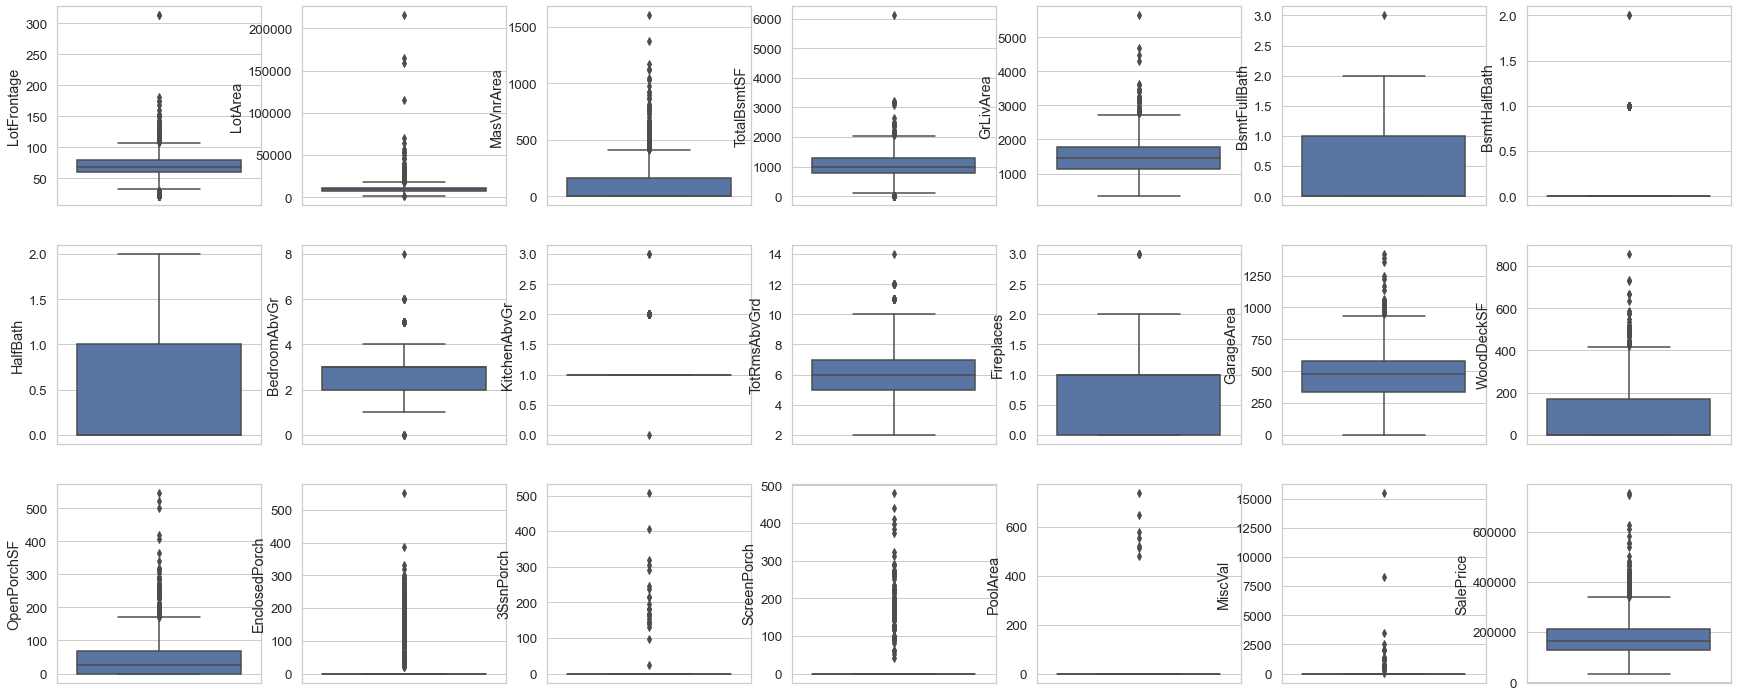

In [33]:
outlier_columns=outlier_info[outlier_info.Outliers>0]["Columns"]
i=int(len(outlier_columns)/3)
plt.figure(figsize=(30,30))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
j=1
for p,c in enumerate(outlier_columns):
    plt.subplot(i,i,j)
    sns.boxplot(y=price_df[c],orient="h")
    plt.ylabel(c)
    j=j+1
plt.show()

In [34]:
# Fix outlier
c=outlier_info[(outlier_info.Columns=="SalePrice")]["Upper Limit"].values
price_df = price_df[price_df["SalePrice"] < c[0]]
c=outlier_info[(outlier_info.Columns=="LotArea")]["Upper Limit"].values
price_df = price_df[price_df["LotArea"] < c[0]]
c=outlier_info[(outlier_info.Columns=="MasVnrArea")]["Upper Limit"].values
price_df = price_df[price_df["MasVnrArea"] < c[0]]
c=outlier_info[(outlier_info.Columns=="LotFrontage")]["Upper Limit"].values
price_df = price_df[price_df["LotFrontage"] < c[0]]
c=outlier_info[(outlier_info.Columns=="GarageArea")]["Upper Limit"].values
price_df = price_df[price_df["GarageArea"] < c[0]]
c=outlier_info[(outlier_info.Columns=="TotalBsmtSF")]["Upper Limit"].values
price_df = price_df[price_df["TotalBsmtSF"] < c[0]]
c=outlier_info[(outlier_info.Columns=="OpenPorchSF")]["Upper Limit"].values
price_df = price_df[price_df["OpenPorchSF"] < c[0]]
c=outlier_info[(outlier_info.Columns=="EnclosedPorch")]["Upper Limit"].values
price_df = price_df[price_df["EnclosedPorch"] < c[0]]

In [35]:
price_df[num_list].describe(percentiles=[0.25,0.5,0.75,0.90,0.95,0.995])

,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
count,"1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00","1,316.00"
mean,68.07,"9,514.87","1,984.74",85.21,"1,025.65","1,463.98",0.41,0.06,1.55,0.37,2.85,1.05,6.40,0.57,1.73,460.12,92.17,40.85,14.04,3.78,14.47,1.89,45.03,"2,007.83","173,206.36"
std,18.01,"3,996.67",20.67,136.78,384.01,460.22,0.51,0.24,0.54,0.50,0.81,0.22,1.54,0.63,0.73,200.10,120.13,53.47,42.28,30.86,53.39,34.45,520.48,1.33,"65,055.85"
min,21.00,"1,300.00","1,950.00",0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,006.00","35,311.00"
25%,60.00,"7,418.75","1,967.00",0.00,793.00,"1,116.75",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,314.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,007.00","129,000.00"
50%,69.00,"9,246.50","1,993.00",0.00,975.50,"1,429.50",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,2.00,472.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,"2,008.00","159,500.00"
75%,78.00,"11,250.00","2,004.00",145.00,"1,258.50","1,720.25",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2.00,576.00,168.00,63.00,0.00,0.00,0.00,0.00,0.00,"2,009.00","205,000.00"
90%,89.00,"13,695.00","2,006.00",296.00,"1,565.50","2,060.00",1.00,0.00,2.00,1.00,4.00,1.00,8.00,1.00,3.00,710.00,256.00,120.00,55.00,0.00,0.00,0.00,0.00,"2,010.00","264,346.50"
95%,99.00,"15,623.25","2,007.00",378.50,"1,698.50","2,291.00",1.00,1.00,2.00,1.00,4.00,1.00,9.00,2.00,3.00,827.00,322.50,155.00,128.00,0.00,154.25,0.00,0.00,"2,010.00","310,375.00"
99.5%,125.70,"26,157.30","2,009.00",596.55,"2,033.85","3,022.20",2.00,1.00,3.00,2.00,6.00,2.00,11.42,2.00,3.00,940.67,526.22,235.42,192.85,225.35,288.00,0.00,"2,000.00","2,010.00","393,321.10"


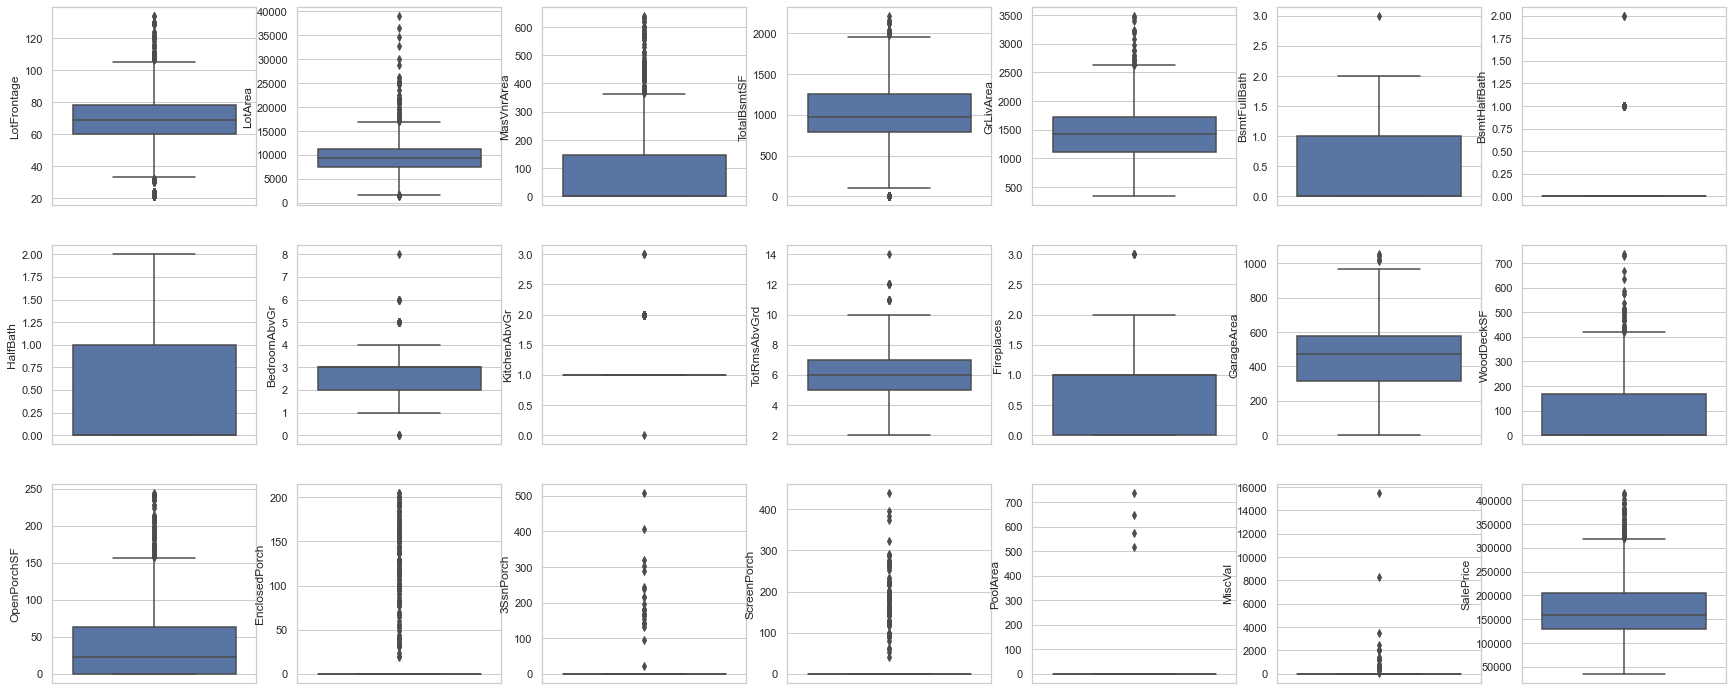

In [36]:
### Post fixing outliers
#outlier_columns=outlier_info[outlier_info.Outliers>0]["Columns"]
i=int(len(outlier_columns)/3)
plt.figure(figsize=(30,30))
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
j=1
for p,c in enumerate(outlier_columns):
    plt.subplot(i,i,j)
    sns.boxplot(y=price_df[c],orient="h")
    plt.ylabel(c)
    j=j+1
plt.show()

In [37]:
print("Shape after outlier correction ",price_df.shape ,"rows & columns.")

Shape after outlier correction  (1316, 72) rows & columns.


### H. Derived Columns

In [38]:
price_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,2-STORY 1946 & NEWER,RL,65.00,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856,GasA,Ex,Y,SBrkr,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,Feb,2008,WD,Normal,208500
1,1-STORY 1946 & NEWER,RL,80.00,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Above Average,Very Good,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262,GasA,Ex,Y,SBrkr,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,May,2007,WD,Normal,181500
2,2-STORY 1946 & NEWER,RL,68.00,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920,GasA,Ex,Y,SBrkr,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,Sep,2008,WD,Normal,223500
4,2-STORY 1946 & NEWER,RL,84.00,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Very Good,Average,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145,GasA,Ex,Y,SBrkr,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,Dec,2008,WD,Normal,250000
5,1-1/2 STORY FINISHED,RL,85.00,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Average,Average,1995,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,Wood,Gd,TA,No,GLQ,Unf,796,GasA,Ex,Y,SBrkr,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,Oct,2009,WD,Normal,143000


In [39]:
price_df["Time_Duration"]=price_df["YrSold"]-price_df["YearRemodAdd"]
price_df.drop(['YrSold','YearRemodAdd'],inplace=True,axis=1)
#price_df["Total_SF"]=price_df["TotalBsmtSF"]+price_df["GrLivArea"]+price_df["GarageArea"]+price_df["PoolArea"]
#price_df["Total_SF_Ratio"]=price_df["Total_SF"]/price_df["LotArea"]
#price_df.head()

In [40]:
print("Shape after dervived columns ",price_df.shape ,"rows & columns.")

Shape after dervived columns  (1316, 71) rows & columns.


### Step 2: Data Visualisation

In [41]:
cat_list,num_list=col_list(price_df)
print("Category Columns:",cat_list)
print("Continous Columns:",num_list)

Category Columns: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
Continous Columns: ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'Tim

#### Visualising Continous Columns

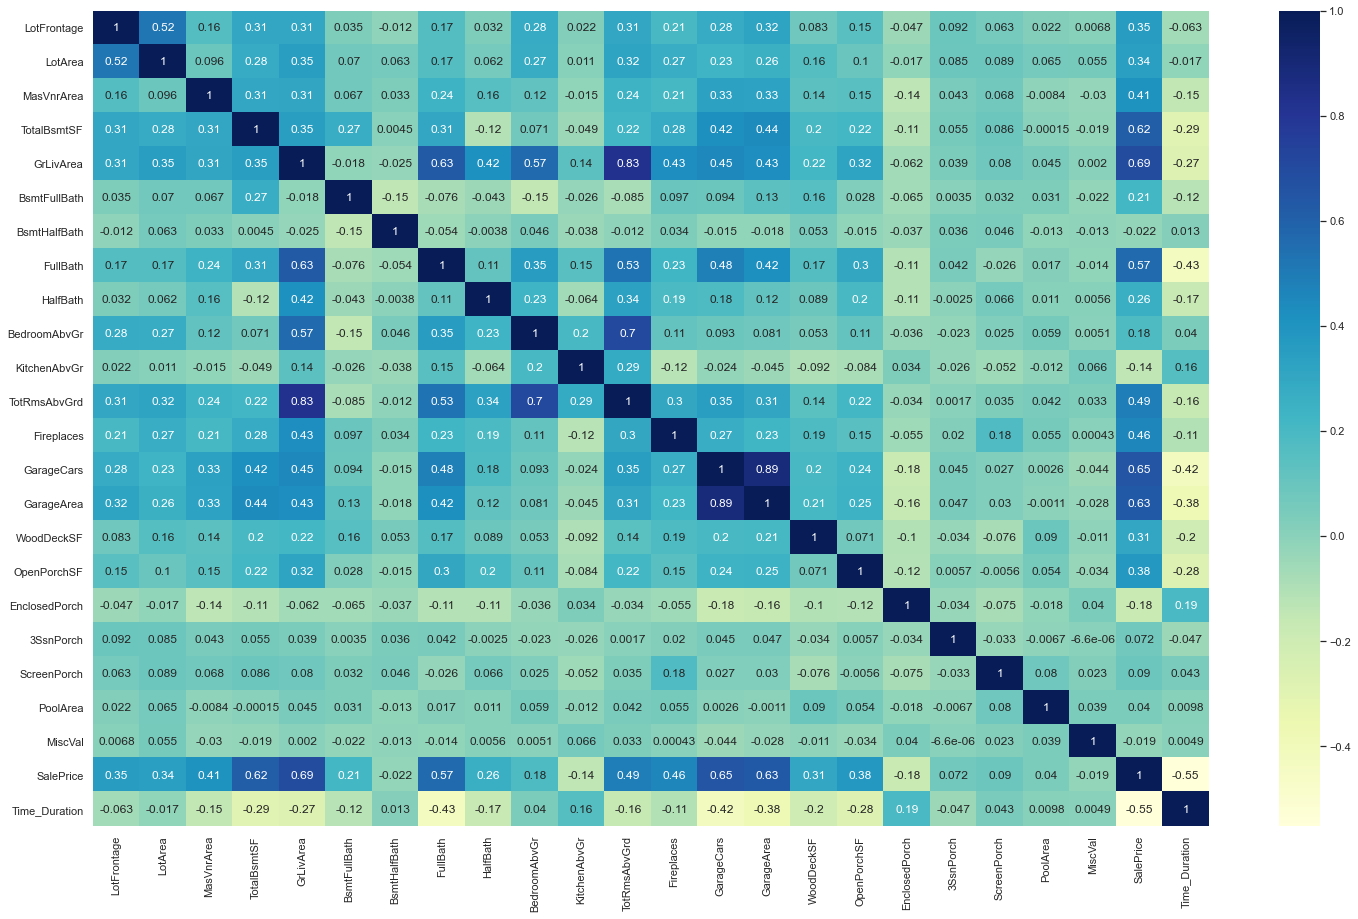

In [42]:
plt.figure(figsize = (25, 15))
sns.heatmap(price_df[num_list].corr(), annot = True, cmap="YlGnBu")
plt.show()

<font color='green'/>**Analysis** - Following Columns have high correlation:
1. LotFrontage with LotArea
2. Sales Price with Total SF, FullBath, TotRmsAbvGrd,Fireplaces,GarageCars,GrLivingArea,TotalBasementSF
3. Living Area with FillPath,BeadroomAbrGr,TotRmsAbvGround,Fireplaces,GarageCars
4. Timeduration of house has negaative correlation with sales price,garagecars,fullpath


Thus, while building the model, we'll have to pay attention to multicollinearity

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

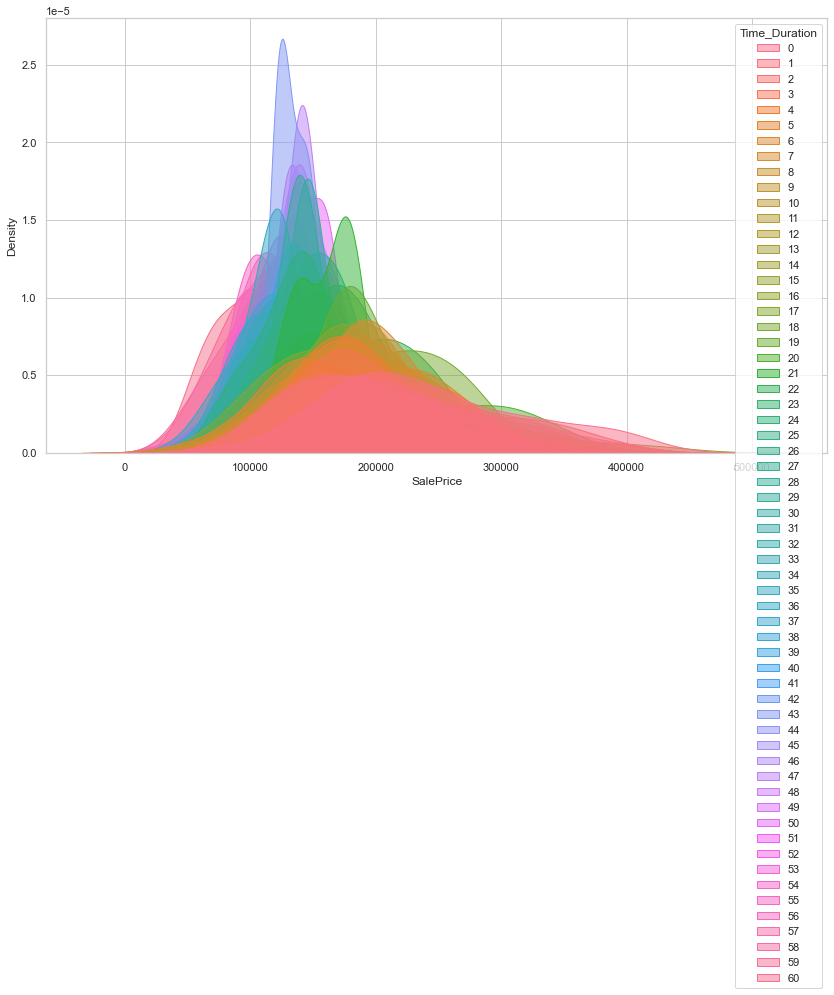

In [43]:
plt.figure(figsize=(14, 8))
sns.kdeplot(data=price_df,x="SalePrice", hue ="Time_Duration", 
            fill=True,common_norm=False, palette="husl", alpha=.5, linewidth=1)

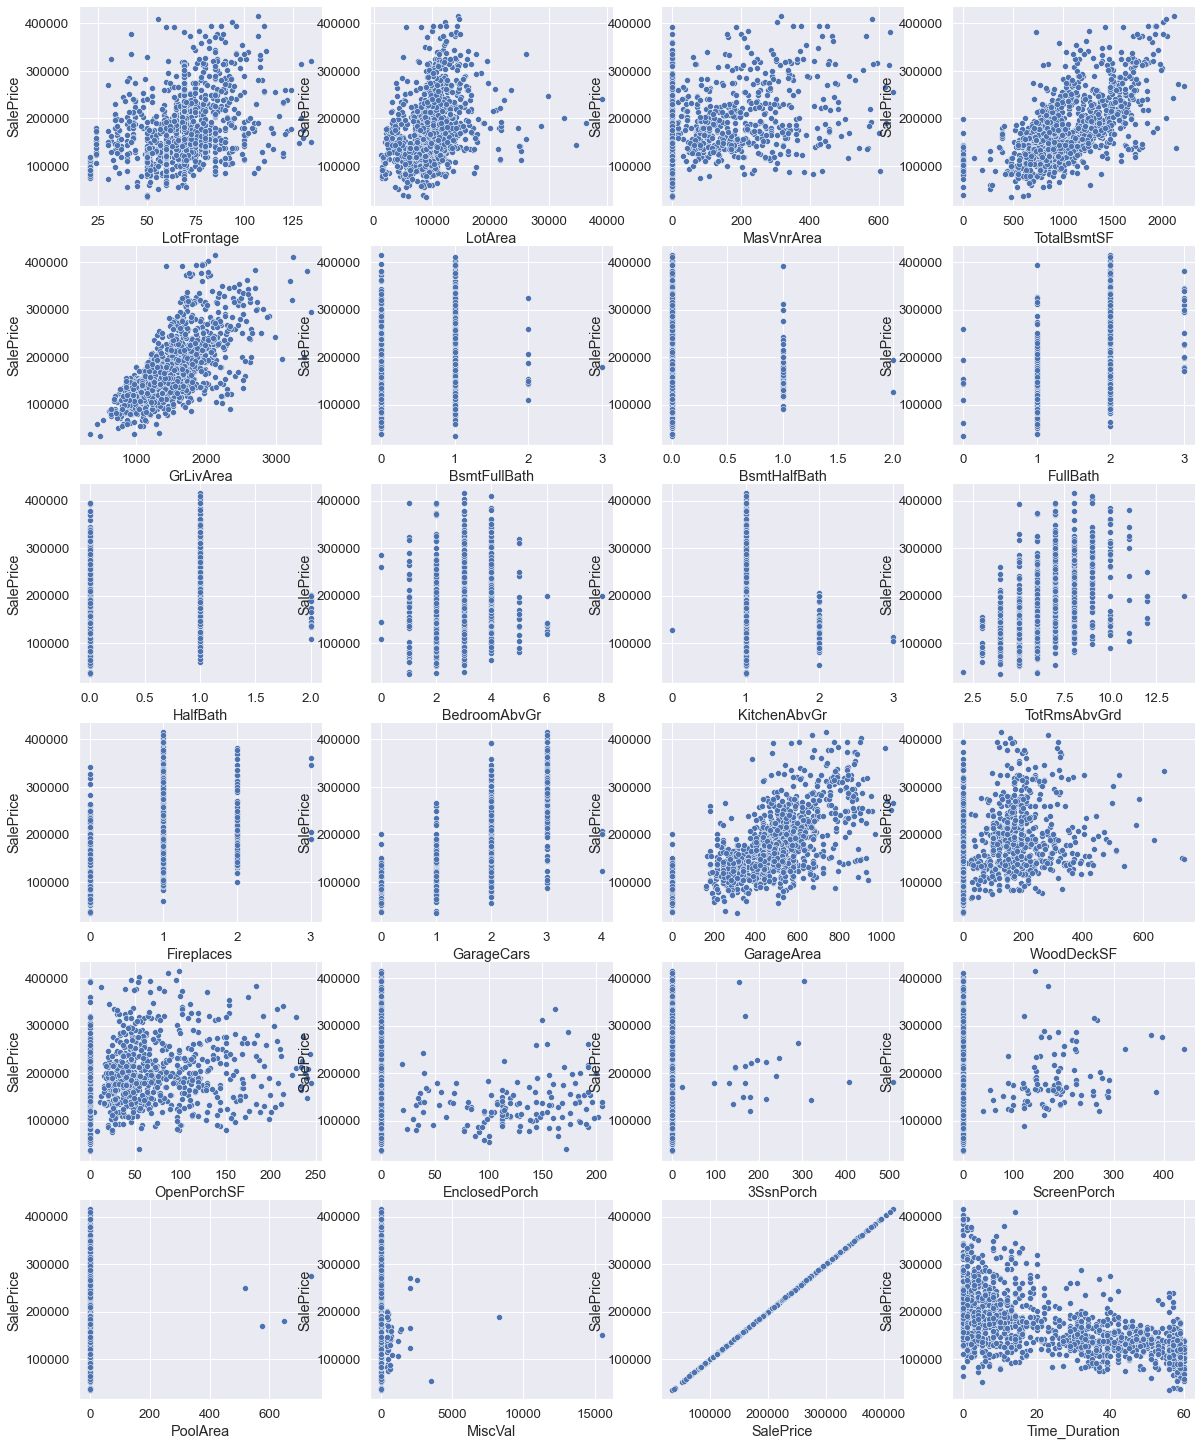

In [44]:
Quality_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','Time_Duration']
plt.figure(figsize=(20, 30))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(num_list):
    plt.subplot(7, 4, i+1)
    sns.scatterplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

#### Visualising Categorical Columns

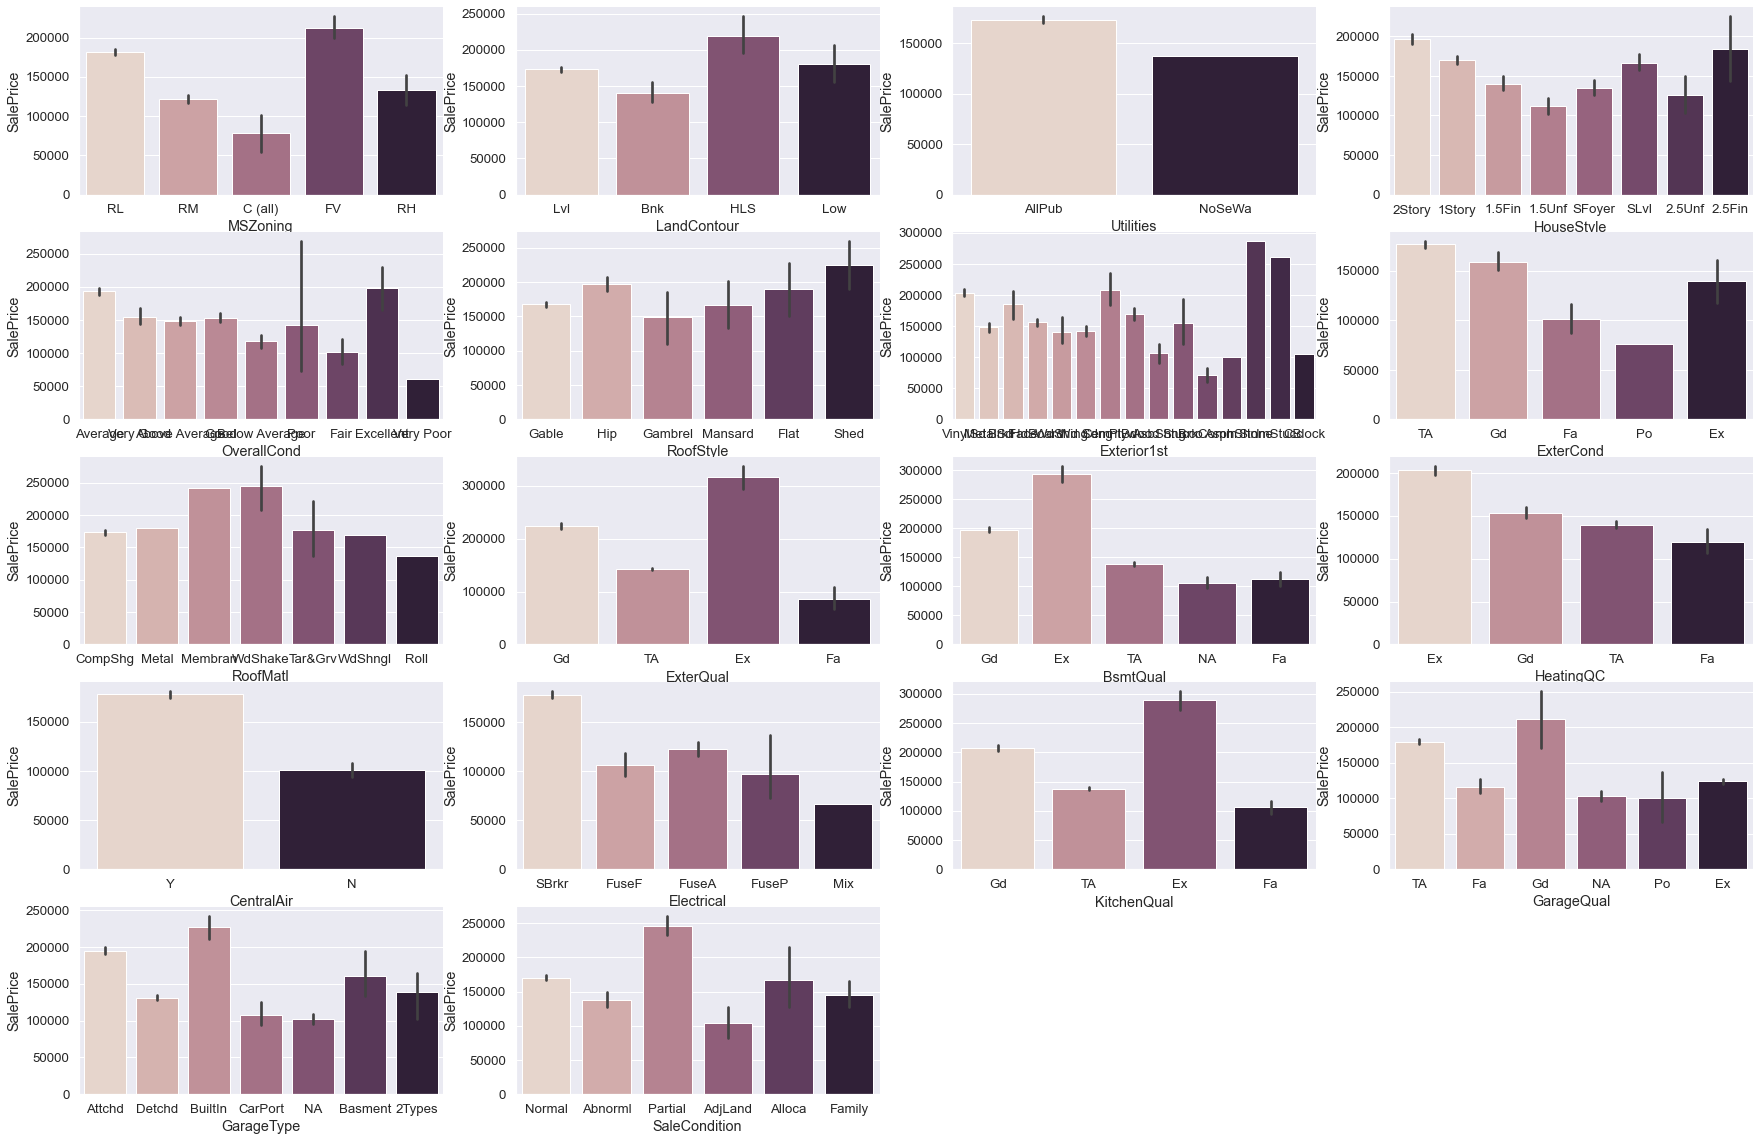

In [45]:
Quality_features = ['MSZoning','LandContour','Utilities','HouseStyle','OverallCond','RoofStyle','Exterior1st','ExterCond',
                    'RoofMatl', 'ExterQual', 'BsmtQual', 'HeatingQC', 'CentralAir', 
                    'Electrical', 'KitchenQual', 'GarageQual','GarageType','SaleCondition']

plt.figure(figsize=(30, 20))
sns.set(font_scale= 1.2)
sns.set_style('darkgrid')

for i, feature in enumerate(Quality_features):
    plt.subplot(5, 4, i+1)
    sns.barplot(data=price_df, x=feature, y='SalePrice', palette="ch:.10")         
sns.despine()

### Step 3: Data Preparation

In [46]:
bkp_df=price_df

In [47]:
price_df=bkp_df
print(price_df.shape)
price_df.head()

(1316, 71)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Time_Duration
0,2-STORY 1946 & NEWER,RL,65.00,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856,GasA,Ex,Y,SBrkr,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,Feb,WD,Normal,208500,5
1,1-STORY 1946 & NEWER,RL,80.00,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Above Average,Very Good,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262,GasA,Ex,Y,SBrkr,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,May,WD,Normal,181500,31
2,2-STORY 1946 & NEWER,RL,68.00,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920,GasA,Ex,Y,SBrkr,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,Sep,WD,Normal,223500,6
4,2-STORY 1946 & NEWER,RL,84.00,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Very Good,Average,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145,GasA,Ex,Y,SBrkr,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,Dec,WD,Normal,250000,8
5,1-1/2 STORY FINISHED,RL,85.00,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Average,Average,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,Wood,Gd,TA,No,GLQ,Unf,796,GasA,Ex,Y,SBrkr,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,Oct,WD,Normal,143000,14


In [48]:
price_categorical = price_df.select_dtypes(include=['object'])
price_numeric = price_df.select_dtypes(exclude=['object'])
num_list=list(price_numeric.columns)
cat_list=list(price_categorical.columns)
price_categorical.head(5)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,NA,Feb,WD,Normal
1,1-STORY 1946 & NEWER,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Above Average,Very Good,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,May,WD,Normal
2,2-STORY 1946 & NEWER,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,Sep,WD,Normal
4,2-STORY 1946 & NEWER,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Very Good,Average,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,Dec,WD,Normal
5,1-1/2 STORY FINISHED,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Average,Average,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,Wood,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NA,Attchd,Unf,TA,TA,Y,NA,MnPrv,Shed,Oct,WD,Normal


### Dummy Variable (Using One Hot Encoding Method)

In [49]:
'''
price_dummies = pd.get_dummies(price_categorical,drop_first=True)
price_df = price_df.drop(list(price_categorical.columns), axis=1)
price_df = pd.concat([price_dummies,price_df],axis = 1)
price_df.head()
'''

'\nprice_dummies = pd.get_dummies(price_categorical,drop_first=True)\nprice_df = price_df.drop(list(price_categorical.columns), axis=1)\nprice_df = pd.concat([price_dummies,price_df],axis = 1)\nprice_df.head()\n'

### Dummy Variable (Using Ordinal Encoding Method)¶

In [50]:
import category_encoders as ce
encoder= ce.OrdinalEncoder(cols=price_categorical.columns,return_df=True)
price_dummies = encoder.fit_transform(price_categorical)
price_df = price_df.drop(list(price_categorical.columns), axis=1)
price_df = pd.concat([price_dummies,price_df],axis = 1)
price_df.head()


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition,LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,Time_Duration
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,65.00,8450,196.00,856,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,208500,5
1,2,1,1,1,1,1,1,2,1,2,2,1,1,2,2,2,1,1,2,2,2,2,1,2,1,1,2,2,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,2,1,1,80.00,9600,0.00,1262,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,181500,31
2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,3,1,1,68.00,11250,162.00,920,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,223500,6
4,1,1,1,1,2,1,1,2,1,3,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,4,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,4,1,1,84.00,14260,350.00,1145,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,250000,8
5,3,1,1,1,2,1,1,1,1,4,1,1,1,3,4,1,1,1,1,1,2,2,1,3,1,1,1,1,1,1,1,1,1,2,1,1,1,2,1,1,1,1,2,2,5,1,1,85.00,14115,0.00,796,1362,1,0,1,1,1,1,5,0,2,480,40,30,0,320,0,0,700,143000,14


In [51]:
print("Shape after dummy encoding ",price_df.shape ,"rows & columns.")

Shape after dummy encoding  (1316, 71) rows & columns.


### Step 4: Splitting and Scaling the data

In [52]:
'''
## Scaling option using sklearn
from sklearn.preprocessing import scale
X = price_df.drop("SalePrice", axis = 1)
y = price_df["SalePrice"]
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
#X_train = scale.fit_transform(X_train)
#X_test = scale.transform(X_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
'''                                                    

'\n## Scaling option using sklearn\nfrom sklearn.preprocessing import scale\nX = price_df.drop("SalePrice", axis = 1)\ny = price_df["SalePrice"]\ncols = X.columns\nX = pd.DataFrame(scale(X))\nX.columns = cols\n#X_train = scale.fit_transform(X_train)\n#X_test = scale.transform(X_test)\nX_train, X_test, y_train, y_test = train_test_split(X, y, \n                                                    train_size=0.7,\n                                                    test_size = 0.3, random_state=100)\n'

In [53]:
### Spliting the dataset
np.random.seed(0)
df_train, df_test = train_test_split(price_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [54]:
### Scaling the data using Standard Scaler
num_list.remove("SalePrice")
scale_list=['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'TotalBsmtSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'Time_Duration']
scaler = StandardScaler()
df_train[num_list] = scaler.fit_transform(df_train[num_list])
df_test[num_list] = scaler.transform(df_test[num_list])
#df_train[scale_list] = scaler.fit_transform(df_train[scale_list])
#df_test[scale_list] = scaler.transform(df_test[scale_list])

In [55]:
df_train.describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition,LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,Time_Duration
count,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00,921.00
mean,4.06,1.33,1.00,1.07,1.39,1.17,1.00,1.58,1.06,10.23,1.33,1.02,1.47,2.15,2.97,2.25,1.24,1.04,3.44,3.43,1.79,1.72,1.15,1.80,2.13,1.23,1.79,2.84,1.41,1.04,1.91,1.06,1.16,1.71,1.17,1.88,1.70,2.06,1.23,1.17,1.11,1.00,1.33,1.04,6.93,1.20,1.35,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,"172,476.17",0.00
std,3.61,0.79,0.05,0.32,0.57,0.58,0.03,1.00,0.25,6.14,1.11,0.24,1.09,1.32,1.65,1.70,0.57,0.40,2.56,2.56,0.62,0.54,0.45,0.98,1.08,0.71,1.25,1.63,1.19,0.29,0.96,0.24,0.56,0.67,0.69,1.06,1.19,0.86,0.76,0.59,0.37,0.07,0.76,0.21,3.45,0.74,0.90,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,"64,940.24",1.00
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-2.62,-2.04,-0.62,-2.68,-2.42,-0.79,-0.25,-2.88,-0.76,-3.56,-0.23,-2.86,-0.92,-2.39,-2.32,-0.80,-0.77,-0.33,-0.11,-0.27,-0.05,-0.08,"35,311.00",-1.14
25%,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,6.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,1.00,1.00,-0.46,-0.50,-0.62,-0.59,-0.75,-0.79,-0.25,-1.02,-0.76,-1.07,-0.23,-0.91,-0.92,-1.01,-0.71,-0.80,-0.77,-0.33,-0.11,-0.27,-0.05,-0.08,"129,000.00",-0.90
50%,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,10.00,1.00,1.00,1.00,2.00,3.00,1.00,1.00,1.00,2.00,3.00,2.00,2.00,1.00,2.00,2.00,1.00,1.00,3.00,1.00,1.00,2.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,7.00,1.00,1.00,0.04,-0.07,-0.62,-0.15,-0.08,-0.79,-0.25,0.85,-0.76,0.17,-0.23,-0.26,0.66,0.37,0.06,-0.80,-0.33,-0.33,-0.11,-0.27,-0.05,-0.08,"158,500.00",-0.41
75%,7.00,1.00,1.00,1.00,2.00,1.00,1.00,2.00,1.00,14.00,1.00,1.00,1.00,2.00,4.00,3.00,1.00,1.00,6.00,5.00,2.00,2.00,1.00,2.00,3.00,1.00,2.00,4.00,1.00,1.00,3.00,1.00,1.00,2.00,1.00,3.00,2.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,10.00,1.00,1.00,0.54,0.43,0.41,0.61,0.55,1.16,-0.25,0.85,1.23,0.17,-0.23,0.39,0.66,0.37,0.59,0.61,0.44,-0.33,-0.11,-0.27,-0.05,-0.08,"202,900.00",0.86
max,15.00,5.00,2.00,3.00,4.00,4.00,2.00,5.00,3.00,25.00,9.00,6.00,5.00,8.00,10.00,8.00,6.00,7.00,14.00,15.00,4.00,4.00,5.00,6.00,5.00,5.00,5.00,7.00,7.00,5.00,4.00,2.00,6.00,4.00,6.00,6.00,7.00,4.00,6.00,6.00,3.00,3.00,5.00,4.00,12.00,9.00,6.00,3.65,7.22,3.92,2.96,4.34,5.07,7.83,2.72,3.22,6.40,4.41,4.93,3.84,3.13,2.94,5.18,3.89,4.65,15.59,7.27,22.78,25.95,"415,298.00",1.79


#### Dividing into X and Y sets for the model building

In [56]:
X_train = df_train.drop("SalePrice", axis = 1)
y_train = df_train["SalePrice"]

##### Dividing test into X and Y sets for the model building

In [57]:
X_test = df_test.drop("SalePrice", axis = 1)
y_test = df_test["SalePrice"]

### Step 5: Model Building & Evaluation
#### Calculating the cross validation score for LR, Lasso,Ridge

In [58]:
models=[LinearRegression(),Lasso(),Ridge()]
cross_metric_train = []
cross_metric_test =[]
for i,x in enumerate(models):
    score=cross_val_score(x,X_train,y_train,cv=10,scoring='r2')
    score2=cross_val_score(x,X_test,y_test,cv=10,scoring='r2')
    cross_metric_train.append(score.mean())
    cross_metric_test.append(score2.mean())
y=pd.Series(cross_metric_test,name='Test')
lr_table = {'Metric': ['LR','Lasso','Ridge'],
        'Train': cross_metric_train
        }
lr_df=pd.DataFrame(lr_table,columns=["Metric","Train"])
final_metric=pd.concat([lr_df,y],axis=1)
final_metric

,Metric,Train,Test
0,LR,"-4,872,456,545,347,646,259,200.00","-2,819,530,052,856,156,520,448.00"
1,Lasso,0.83,0.81
2,Ridge,0.83,0.81


### Linear Regression

In [59]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.intercept_)
print(lm.coef_)

169440.0394428905
[ 1.82222918e+02  4.17753780e+02 -1.90837725e+04 -3.37154194e+03
  1.50583112e+03  3.05814759e+03 -3.16284429e+04  5.57222675e+02
  1.67288917e+02  2.03114555e+01 -2.61881900e+03 -8.76284995e+03
 -3.03802411e+03 -1.99767734e+03  2.03381427e+03 -7.85294982e+02
  3.80862328e+03 -3.36535279e+03 -1.63084022e+03  1.73229367e+03
  3.41988684e+03 -1.96441976e+03 -2.66473585e+02 -3.35196608e+02
 -4.18598641e+02  9.29458272e+02  2.56176176e+03 -1.49654944e+03
  6.77335502e+02  4.66893406e+03 -4.64764993e+03 -7.14421725e+03
  1.70103176e+03  4.47731417e+03 -7.96681244e+03  3.27113239e+03
 -3.09229322e+02  1.81060387e+03  5.28958859e+03 -4.21992501e+03
 -8.73275482e+03  7.07003546e+04 -1.45511333e+03  6.51668056e+02
 -2.99171685e+02  3.19120139e+03 -1.45046008e+02  1.38920135e+03
  2.13010832e+03  5.45932984e+03  1.17810719e+04  2.77486299e+04
  4.35085078e+03  3.01512511e+02  4.36710190e+03  1.36822883e+03
 -4.41169468e+03 -7.77553231e+03 -1.20260977e+03  1.89536192e+03
  7.097

In [60]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8656691519539007
0.8330837530861592
521184278128.97003
281076192208.5056
565889552.8001846
711585296.730394


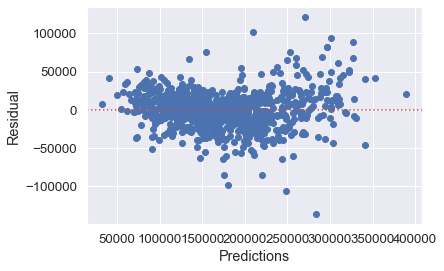

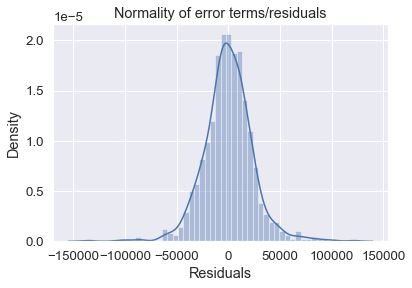

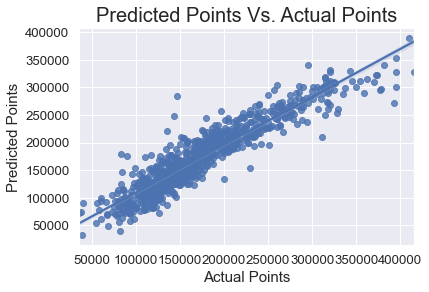

In [61]:
#### Assumption graphs for Linear Regression Train Data
assumption_graph(y_train,y_pred_train)

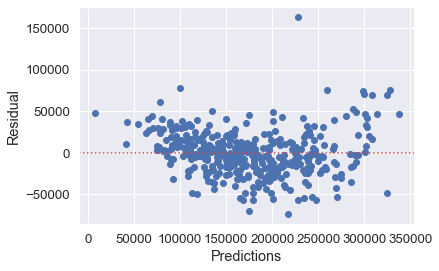

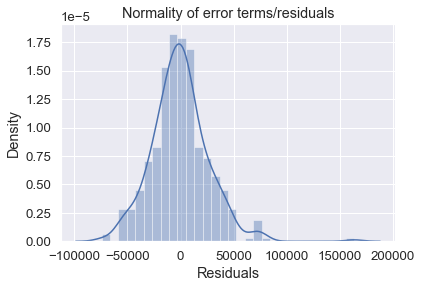

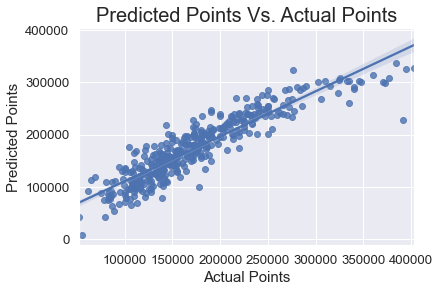

In [62]:
#### Assumption graphs for Linear Regression Test Data
assumption_graph(y_test,y_pred_test)

**Analysis** - Linear Regression features are not linear in natures as the residual terms are showing pattern in plot against predicted value.Hence trying polynomial Regression of degree 2

#### Polynomial Regression

In [63]:
degree=2
polyreg = PolynomialFeatures(degree)
X_poly = polyreg.fit_transform(X_train) # Transform the variable X to 1, X, X^2
linreg = LinearRegression()
linreg.fit(X_poly, y_train)

LinearRegression()

In [64]:
print(linreg.intercept_)
print(linreg.coef_)

211664.43698524343
[ -11.60414029  256.81445662  -22.92719783 ... -545.48377501   23.94593642
 2362.76422897]


In [65]:
y_pred_train = linreg.predict(polyreg.fit_transform(X_train))
y_pred_test = linreg.predict(polyreg.fit_transform(X_test))
poly_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
poly_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
poly_metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
poly_metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
poly_metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
poly_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
poly_metric.append(mse_test_lr**0.5)

1.0
0.2007915861272903
7.542127475535692e-16
1345815412853.699
8.189063491352543e-19
3407127627.477719


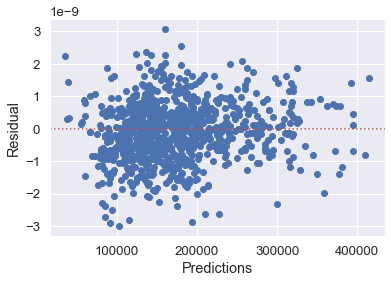

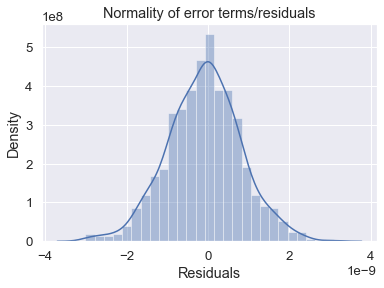

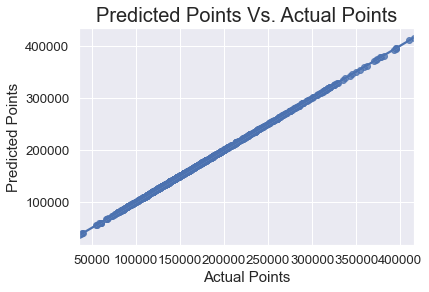

In [66]:
#### Assumption graphs for Polyregression  Train Data
assumption_graph(y_train,y_pred_train)

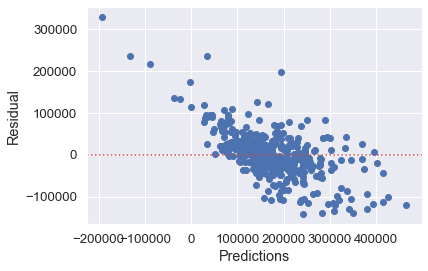

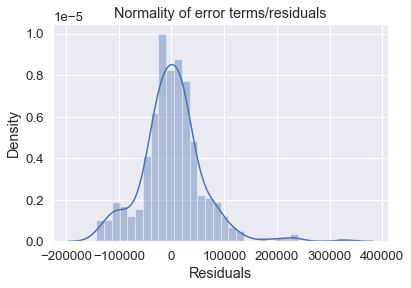

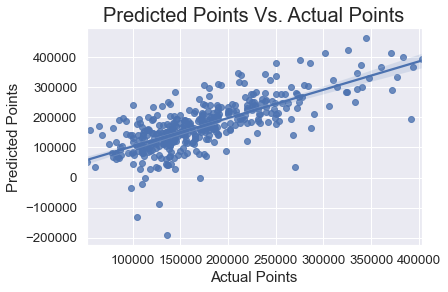

In [67]:
#### Assumption graphs for Polyregression  Test Data
assumption_graph(y_test,y_pred_test)

**Analysis** - Residuals are following all the assumptions of linear regression

### Step 6: Regualization using Ridge and Lasso

#### Ridge Regression

In [84]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
estimator = Ridge()
# cross validation
folds = 10
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#model_cv.fit(polyreg.fit_transform(X_train),y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [85]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_['alpha'])

50


In [86]:
#Fitting Ridge model for alpha = 5 and printing coefficients which have been penalised
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
#ridge.fit(X_poly,y_train)

Ridge(alpha=100)

In [87]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

#y_pred_train = ridge.predict(polyreg.fit_transform(X_train))
#y_pred_test = ridge.predict(polyreg.fit_transform(X_test))

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8583160115481138
0.8358509873883527
549713400293.49243
276416348155.0336
596865798.3642697
699788223.1773003


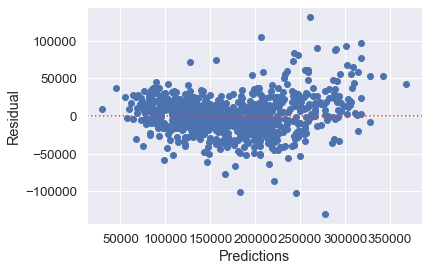

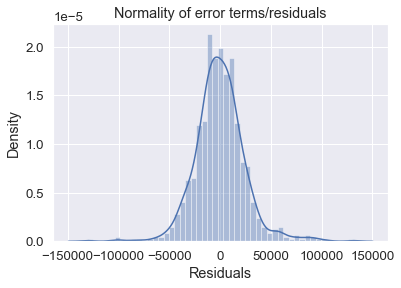

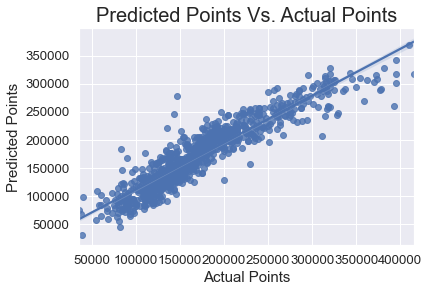

In [88]:
#### Assumption graphs for Ridge Regression Train Data
assumption_graph(y_train,y_pred_train)

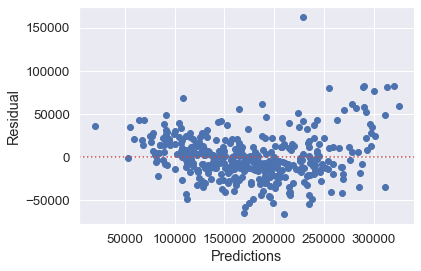

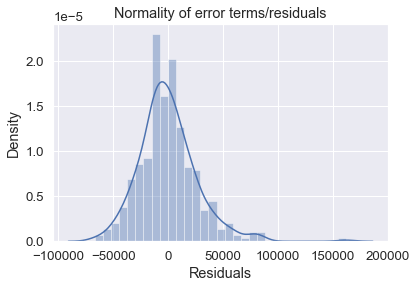

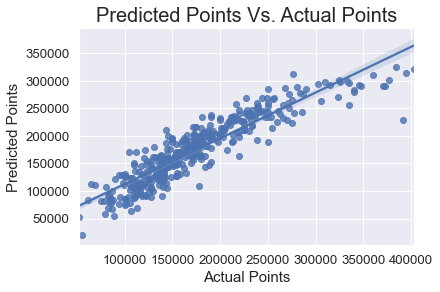

In [89]:
#### Assumption graphs for Ridge Regression Test Data
assumption_graph(y_test,y_pred_test)

**Analysis** - Residuals are following all the assumptions of linear regression

### Lasso Regression

In [90]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
#params = {'alpha': [0.001, 0.0001, 0.0005, 0.005,0.003 ]}
estimator = Lasso()
# cross validation
folds = 10
model_cv = GridSearchCV(estimator = estimator, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#model_cv.fit(polyreg.fit_transform(X_train), y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [92]:
print(model_cv.best_params_)

{'alpha': 500}


In [100]:
#Fitting Lasso model for alpha = 0.001 and printing coefficients which have been penalised
alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 
#lasso.coef_

Lasso(alpha=500)

In [101]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

#y_pred_train = ridge.predict(polyreg.fit_transform(X_train))
#y_pred_test = ridge.predict(polyreg.fit_transform(X_test))

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8583160115481138
0.8358509873883527
549713400293.49243
276416348155.0336
596865798.3642697
699788223.1773003


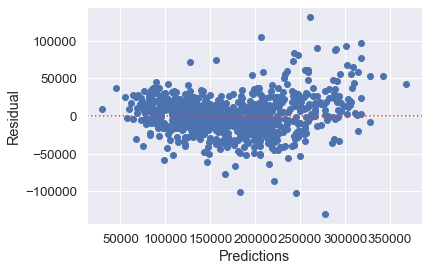

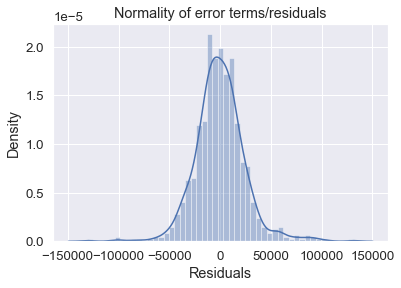

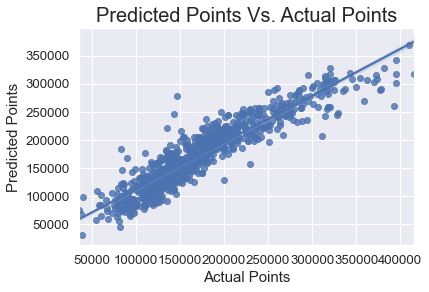

In [102]:
#### Assumption graphs for Lasso Regression Train Data
assumption_graph(y_train,y_pred_train)

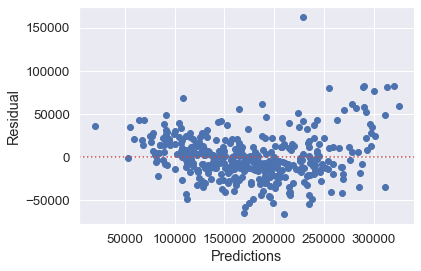

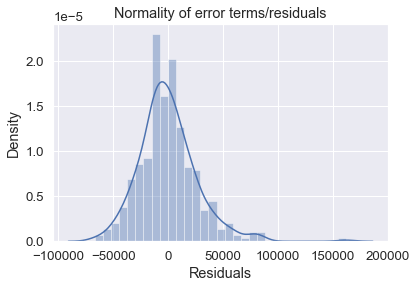

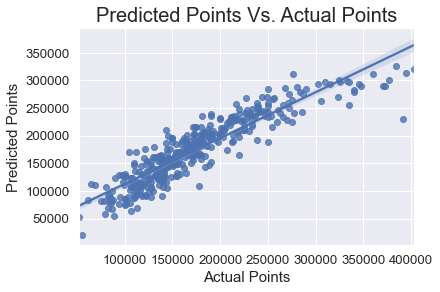

In [103]:
#### Assumption graphs for Lasso Regression Test Data
assumption_graph(y_test,y_pred_test)

**Analysis** - Residuals are following all the assumptions of linear regression

In [104]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
poly_metric = pd.Series(poly_metric,name = 'Polynomial Regression')
rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')
final_metric = pd.concat([lr_metric, poly_metric,rg_metric, ls_metric], axis = 1)
final_metric

,Metric,Linear Regression,Polynomial Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.87,1.00,0.86,0.86
1,R2 Score (Test),0.83,0.20,0.84,0.84
2,RSS (Train),"521,184,278,128.97",0.00,"549,713,400,293.49","549,713,400,293.49"
3,RSS (Test),"281,076,192,208.51","1,345,815,412,853.70","276,416,348,155.03","276,416,348,155.03"
4,MSE (Train),"23,788.43",0.00,"24,430.84","24,430.84"
5,MSE (Test),"26,675.56","58,370.61","26,453.51","26,453.51"


**Analysis** - From the above table, the worst r2 score is from linear regression where as the best model can be ridge or lasso. We are selecting lasso due to feature selection

#### Lets observe the changes in the coefficients after regularization

In [105]:
betas = pd.DataFrame(X_train.columns,columns=["Features"])
betas.rows = df_train.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.sort_values(by=['Ridge'],ascending=False).head(100)

,Features,Linear,Ridge,Lasso
51,GrLivArea,"27,748.63","18,801.79","26,328.94"
50,TotalBsmtSF,"11,781.07","11,134.05","12,075.37"
61,GarageArea,"4,698.91","5,938.93","4,664.70"
60,GarageCars,"7,097.31","5,898.76","6,689.30"
49,MasVnrArea,"5,459.33","5,431.39","4,899.96"
54,FullBath,"4,367.10","5,397.17","3,991.42"
52,BsmtFullBath,"4,350.85","4,156.00","4,072.22"
59,Fireplaces,"1,895.36","3,403.37","2,449.17"
35,FireplaceQu,"3,271.13","3,233.63","3,150.95"
16,RoofStyle,"3,808.62","3,081.01","1,746.50"


In [106]:
ridge_sorted_betas=betas.sort_values(by=['Ridge'],ascending=False).head(20)
lasso_sorted_betas=betas.sort_values(by=['Lasso'],ascending=False).head(20)

plot_bar_chart(ridge_sorted_betas,"Features","Ridge")
plot_bar_chart(lasso_sorted_betas,"Features","Lasso")

**Analysis** - Above charts show the top 30 features from both Lasso & Ridge Models